# Targeting Direct Marketing with Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## Contents

1. [Overview](#Overview)
1. [Preperation](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Overview
In this workshop, you will learn how to use <b> Amazon SageMaker </b> to build, train and deploy a machine learning (ML) model using the popular XGBoost Algorithm.   

Amazon SageMaker is a modular, fully managed machine learning service that enables developers and data scientists to build, train, and deploy ML models at scale.  Taking ML models from concept to production is typically complex and time-consuming. You have to manage large amounts of data to train the model, choose the best algorithm for training it, manage the compute capacity while training it, and then deploy the model into a production environment. Amazon SageMaker reduces this complexity by making it much easier to build and deploy ML models. After you choose the right algorithms and frameworks from the wide range of choices available, Amazon SageMaker manages all of the underlying infrastructure to train your model at petabyte scale, and deploy it to production.

In this exercise, you have been asked to to develop a machine learning model to predict whether a customer will enroll for a certificate of deposit (CD), after the customer has been contacted through mail, email, phone, etc.  The model will be trained on the marketing dataset that contains information on customer demographics, responses to marketing events, and environmental factors. Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer.  

The data has been labeled for your convenience and a column in the dataset identifies whether the customer is enrolled for a product offered by the bank. A version of this dataset is publicly available  from the ML repository curated by the University of California, Irvine (https://archive.ics.uci.edu/ml/datasets/bank+marketing). This tutorial implements a supervised machine learning model, since the data is labeled. (Unsupervised learning occurs when the datasets are not labeled.)

The steps include:

* Downloading training data into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

## Feature Engineering
In this part of the tutorial, you will learn about the highlighted part of machine learning process:
![png](./image/ML-pipeline.JPG)

---

## Data

In this step you will use your Amazon SageMaker Studio notebook to preprocess the data that you need to train your machine learning model.



Execute each cell by pressing <b> Shift+Enter </b> in each of the cells. While the code runs, an * appears between the square brackets as pictured in the first screenshot to the right. After a few seconds, the code execution will complete, the * will be replaced with the number 1.



Let's start by:

- Upgrading Pandas (Python library for scientific computing) to the latest version
- Specifying the S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- Specifying the IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).
- Importing the necessary Python libraries that we will use throughout the analysis and define a few environment variables in your Jupyter environment.

In [3]:
# cell 01 - upgrade Pandas to the latest version
!conda update pandas -y

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::nbclient==0.5.2=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - conda-forge/noarch::qdarkstyle==2.8.1=pyhd8ed1ab_2
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/linux-64::widgetsnbextension==3.5.1=py36h5fab9bb_4
  - conda-forge/noarch::flake8==3.8.4=py_0
  - conda-forge/noarch::ipywidgets==7.6.3=pyhd3deb0d_0
  - conda-forge/noarch::typing-extensions==3.7.4.3=0
  - conda-forge/noarch::path.py==12.5.0=0
  - conda-forge/noarch::dask==2021.2.0=pyhd8ed1ab_0
  - conda-forge/noarch::nbformat==5.1.2=pyhd8ed1ab_1
  - conda-forge/linux-64::path==15.1.2=py36h5fab9bb_0
  - conda-forge/linux-64::nbconvert==6.0.7=py36h5fab9bb_3
  - conda-forge/linux-64::distributed==2021.2.0=py36h5fab9bb_0
  - conda-f

In [4]:
# cell 02 - Specify S3 bucket and prefix
import boto3
import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session

bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role used to give training and hosting access to your data
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [5]:
# cell 03 = bring in the Python libraries uses throughout the analysis
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

In [6]:
# cell 04
pd.__version__

'1.1.5'

Make sure pandas version is set to 1.2.4 or later. If it is not the case, restart the kernel before going further

---

## Downloading data
Download the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket by running the 

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


In [7]:
# cell 05
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip

with zipfile.ZipFile('bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

--2022-02-16 22:07:58--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.218.217
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.218.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip.1’

bank-additional.zip 100%[===================>] 422.68K  --.-KB/s    in 0.03s   

2022-02-16 22:07:59 (12.7 MB/s) - ‘bank-additional.zip.1’ saved [432828/432828]



In the next cell, you will load the dataset into a pandas dataframe.

In [8]:
# cell 06
data = pd.read_csv('./bank-additional/bank-additional-full.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Let's talk about the data.  At a high level, we can see:

* We have a little over 40K customer records, and 20 features for each customer
* The features are mixed; some numeric, some categorical
* The data appears to be sorted, at least by `time` and `contact`, maybe more

_**Specifics on each of the features:**_

*Demographics:*
* `age`: Customer's age (numeric)
* `job`: Type of job (categorical: 'admin.', 'services', ...)
* `marital`: Marital status (categorical: 'married', 'single', ...)
* `education`: Level of education (categorical: 'basic.4y', 'high.school', ...)

*Past customer events:*
* `default`: Has credit in default? (categorical: 'no', 'unknown', ...)
* `housing`: Has housing loan? (categorical: 'no', 'yes', ...)
* `loan`: Has personal loan? (categorical: 'no', 'yes', ...)

*Past direct marketing contacts:*
* `contact`: Contact communication type (categorical: 'cellular', 'telephone', ...)
* `month`: Last contact month of year (categorical: 'may', 'nov', ...)
* `day_of_week`: Last contact day of the week (categorical: 'mon', 'fri', ...)
* `duration`: Last contact duration, in seconds (numeric). Important note: If duration = 0 then `y` = 'no'.
 
*Campaign information:*
* `campaign`: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* `pdays`: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* `previous`: Number of contacts performed before this campaign and for this client (numeric)
* `poutcome`: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

*External environment factors:*
* `emp.var.rate`: Employment variation rate - quarterly indicator (numeric)
* `cons.price.idx`: Consumer price index - monthly indicator (numeric)
* `cons.conf.idx`: Consumer confidence index - monthly indicator (numeric)
* `euribor3m`: Euribor 3 month rate - daily indicator (numeric)
* `nr.employed`: Number of employees - quarterly indicator (numeric)

*Target variable:*
* `y`: Has the client subscribed a term deposit? (binary: 'yes','no')

### Exploration
7. Let's start exploring the data.  First, let's understand how the features are distributed.

col_0,% observations
job,
admin.,0.253035
blue-collar,0.224677
entrepreneur,0.035350
housemaid,0.025736
management,0.070992
retired,0.041760
self-employed,0.034500
services,0.096363
student,0.021244


col_0,% observations
marital,
divorced,0.111974
married,0.605225
single,0.280859
unknown,0.001942


col_0,% observations
education,
basic.4y,0.101389
basic.6y,0.055647
basic.9y,0.146766
high.school,0.231014
illiterate,0.000437
professional.course,0.127294
university.degree,0.295426
unknown,0.042027


col_0,% observations
default,
no,0.791201
unknown,0.208726
yes,0.000073


col_0,% observations
housing,
no,0.452122
unknown,0.024036
yes,0.523842


col_0,% observations
loan,
no,0.824269
unknown,0.024036
yes,0.151695


col_0,% observations
contact,
cellular,0.634748
telephone,0.365252


col_0,% observations
month,
apr,0.063902
aug,0.149995
dec,0.004419
jul,0.174177
jun,0.129115
mar,0.013256
may,0.334296
nov,0.099568
oct,0.017432


col_0,% observations
day_of_week,
fri,0.190031
mon,0.206711
thu,0.209357
tue,0.196416
wed,0.197485


col_0,% observations
poutcome,
failure,0.103234
nonexistent,0.863431
success,0.033335


col_0,% observations
y,
no,0.887346
yes,0.112654


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


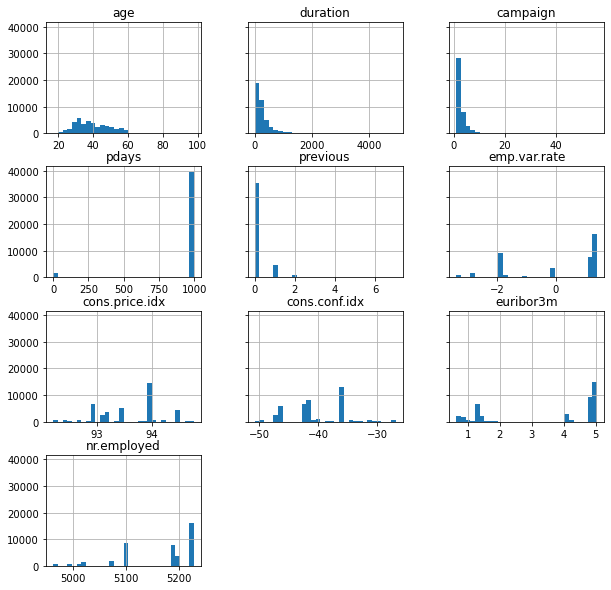

In [9]:
# cell 07
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

Notice that:

* Almost 90% of the values for our target variable `y` are "no", so most customers did not subscribe to a term deposit.
* Many of the predictive features take on values of `unknown`.  Some are more common than others.  We should think carefully as to what causes a value of "unknown" (are these customers non-representative in some way?) and how we that should be handled.
  * Even if `unknown` is included as it's own distinct category, what does it mean given that, in reality, those observations likely fall within one of the other categories of that feature?
* Many of the predictive features have categories with very few observations in them.  If we find a small category to be highly predictive of our target outcome, do we have enough evidence to make a generalization about that?
* Contact timing is particularly skewed.  Almost a third in May and less than 1% in December.  What does this mean for predicting our target variable next December?
* There are no missing values in our numeric features.  Or missing values have already been imputed.
  * `pdays` takes a value near 1000 for almost all customers.  Likely a placeholder value signifying no previous contact.
* Several numeric features have a very long tail.  Do we need to handle these few observations with extremely large values differently?
* Several numeric features (particularly the macroeconomic ones) occur in distinct buckets.  Should these be treated as categorical?



Next, let's look at how our features relate to the target that we are attempting to predict.

y,no,yes
job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


age


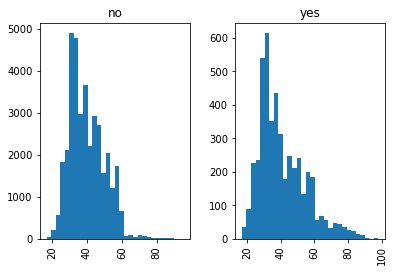

duration


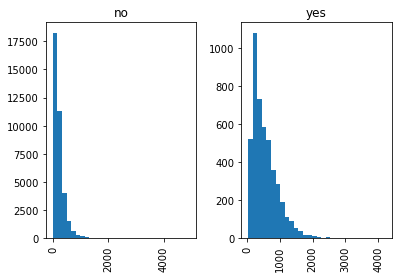

campaign


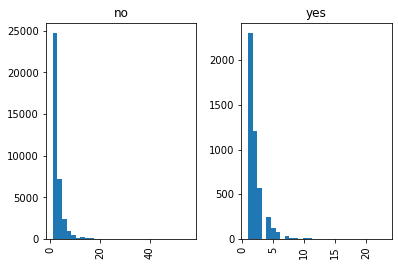

pdays


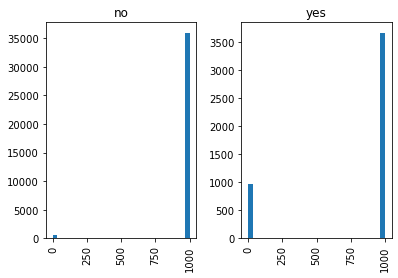

previous


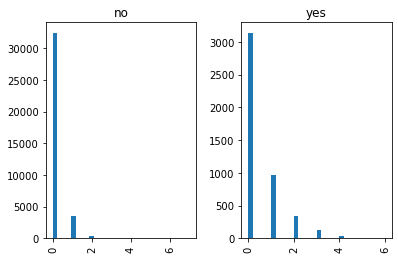

emp.var.rate


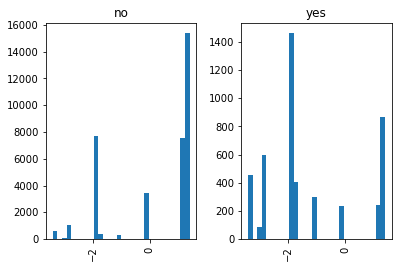

cons.price.idx


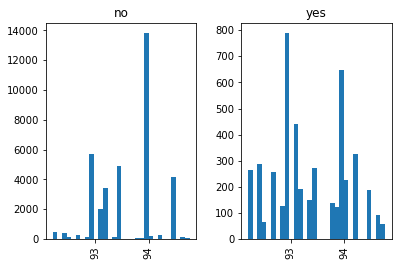

cons.conf.idx


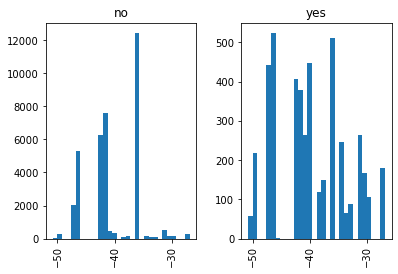

euribor3m


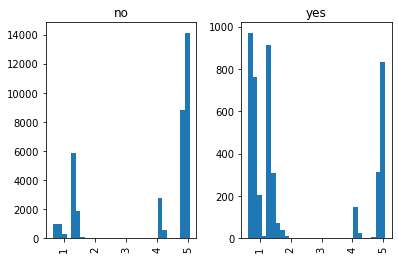

nr.employed


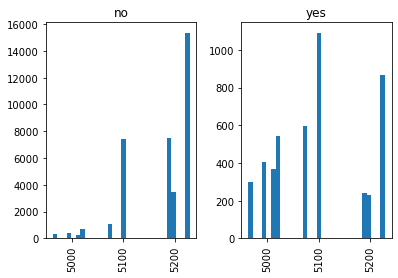

In [10]:
# cell 08
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

Notice that:

* Customers who are-- blue-collar", "married", "unknown" default status, contacted by "telephone", and/or in "may" are a substantially lower portion of "yes" than "no" for subscribing.
* Distributions for numeric variables are different across "yes" and "no" subscribing groups, but the relationships may not be straightforward or obvious.



9. Now let's look at how our features relate to one another.

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


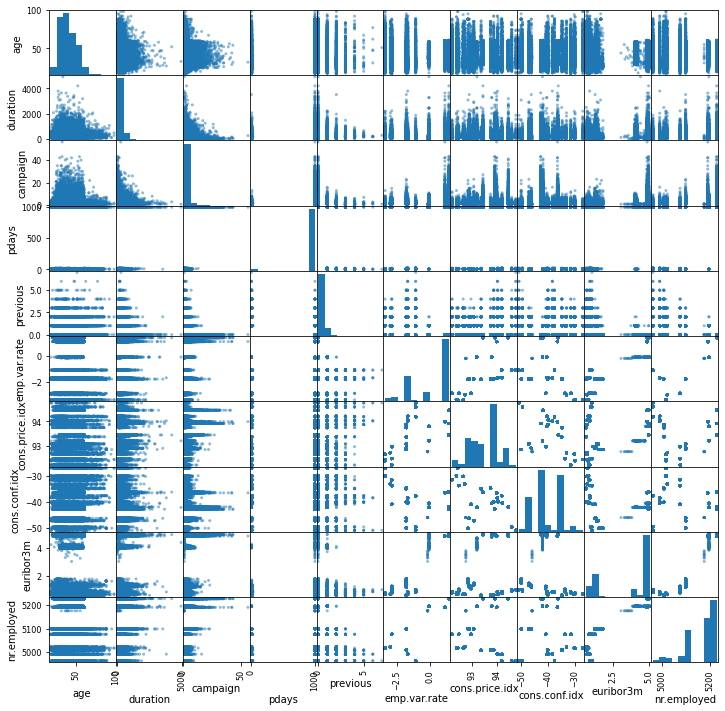

In [11]:
# cell 09 -- using a correlation matrix and scatter matrix understand how features are related to one another
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

Notice that:
* Features vary widely in their relationship with one another.  Some with highly negative correlation, others with highly positive correlation.
* Relationships between features is non-linear and discrete in many cases.

### Transformation

Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

* <b>Handling missing values:</b> Some machine learning algorithms are capable of handling missing values, but most would rather not.  Options include:
 * <b>Removing observations with missing values:</b> This works well if only a very small fraction of observations have incomplete information.
 * <b>Removing features with missing values</b>: This works well if there are a small number of features which have a large number of missing values.
 * <b>Imputing missing values</b>: Entire [books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
* <b>Converting categorical to numeric</b>: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* <b>Oddly distributed data</b>: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.  These buckets can then be treated as categorical variables and included in the model when one hot encoded.
* Handling more complicated data types: Mainpulating images, text, or data at varying grains is left for other notebook templates.

Luckily, some of these aspects have already been handled for us, and the algorithm we are showcasing tends to do well at handling sparse or oddly distributed data.  Therefore, let's keep pre-processing simple.

In [15]:
# cell 10 - Transformation
# Create a new indicator variable, 'no_previous_contact' which takes on a value 0 when pdays = 999
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
# Create a new indicator variable, 'not_working' which takes on a value 1 if job is 'student' or 'retired' or 'unemployed'
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
# Convert all categorial values into numeric using one-hot encoding
model_data = pd.get_dummies(data)                                                                  # Convert categorical variables to sets of indicators

Another question to ask yourself before building a model is whether certain features will add value in your final use case.  For example, if your goal is to deliver the best prediction, then will you have access to that data at the moment of prediction?  Knowing it's raining is highly predictive for umbrella sales, but forecasting weather far enough out to plan inventory on umbrellas is probably just as difficult as forecasting umbrella sales without knowledge of the weather.  So, including this in your model may give you a false sense of precision.

Following this logic, let's remove the economic features [`emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`,`nr.employed`] and `duration` from our data as they would need to be forecasted with high precision to use as inputs in future predictions.

  Even if we were to use values of the economic indicators from the previous quarter, this value is likely not as relevant for prospects contacted early in the next quarter as those contacted later on.

In [16]:
# cell 11
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

### Splitting data
When building a model whose primary goal is to predict a target value on new data, it is important to understand <b> overfitting</b>.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.
The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on <b>"new"</b> data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  

Use Numpy to split data into 3 groups. The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [17]:
# cell 12 - split our data into 3 channels: train, test,validation sets
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

### Transform data into format expected by SageMaker built-in algorithm
Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  
 - For this example, we'll stick to CSV.  
 - The first column must be the target variable and the CSV should not include headers.  
Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [18]:
# cell 13
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

13. Now we'll upload the final data to S3 for Amazon SageMaker's managed training to pickup.

In [19]:
# cell 14
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

#### Verify Data Upload (Optional)
At this point, you can check the S3 bucket through the console to make sure you have uploaded the `train.csv` and `validation.csv`. The steps are as follows:
1. From the AWS Console Main Page, load S3.
2. Find your bucket name, that corresponds to your chosen region (e.g. "ap-southeast-2")
3. Click on “sagemaker/” and then on “DEMO-xgboost-dm/”. You will see a “train/” and “validation/” folder.
4. You can have a look inside of each folder to make sure that the “train.csv” file is there as well as the “validation.csv” file.



---

## Training
We have so far applied data engineering to clean and prepare your data for model building and training.  
In the next section, we will learn about the highlighted phases in the picture 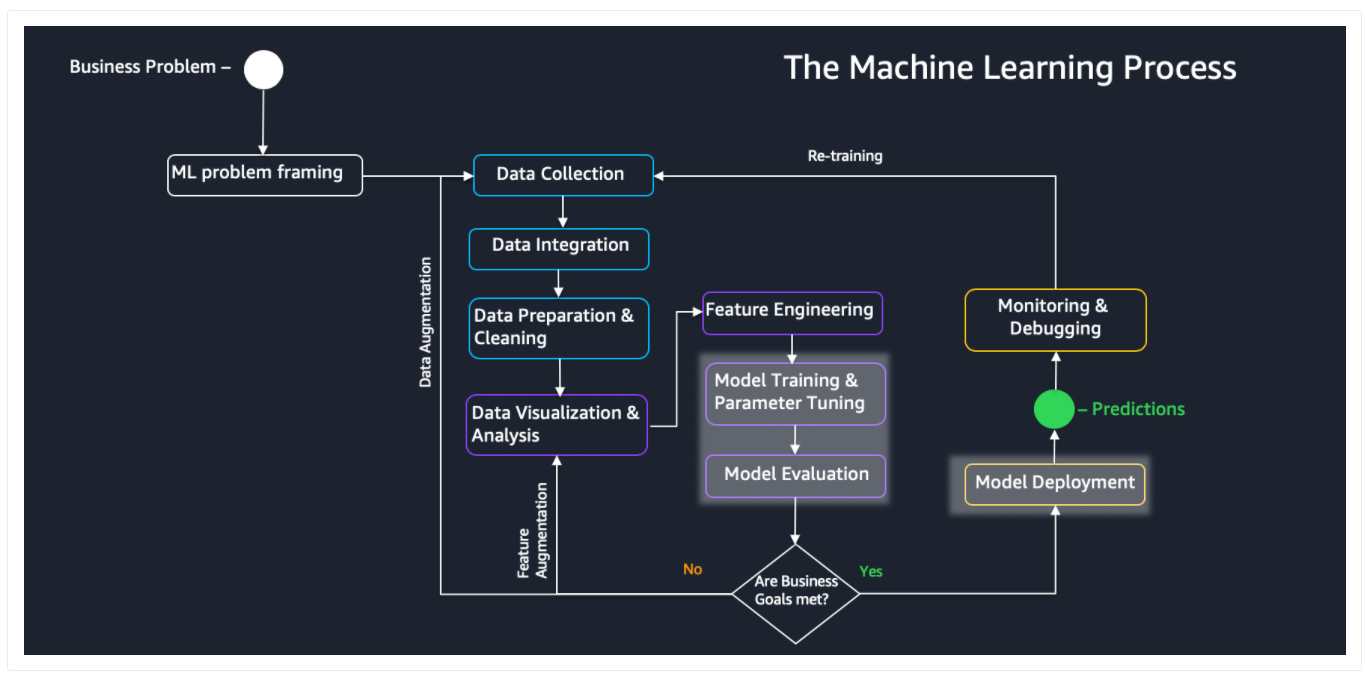

Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make <b> gradient boosted trees </b> a good candidate algorithm. Specifically, we will learn how to train, tune and deploy an XGBoost model using SageMaker's built-in <b> XGBoost algorithm </b>.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [23]:
# from sagemaker import image_uris
# cell 15 - specify the XGBoost ECR container location
print(boto3.Session().region_name)
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

us-west-2


In [24]:
#pip list


15. Specify training and validation data set locations, and content type as CSV. 

In [25]:
# cell 16
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Define training parameters to the SageMaker `Estimator`.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. SageMaker session
You also define the tuning hyperparameters by invoking `set_hyperparameters' 

And then call the `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [26]:
# cell 17
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2022-02-16 22:26:29 Starting - Starting the training job...
2022-02-16 22:26:53 Starting - Launching requested ML instancesProfilerReport-1645050389: InProgress
.........
2022-02-16 22:28:13 Starting - Preparing the instances for training.........
2022-02-16 22:29:53 Downloading - Downloading input data...
2022-02-16 22:30:25 Training - Training image download completed. Training in progress..Arguments: train
[2022-02-16:22:30:27:INFO] Running standalone xgboost training.
[2022-02-16:22:30:27:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8338.38mb
[2022-02-16:22:30:27:INFO] Determined delimiter of CSV input is ','
[22:30:27] S3DistributionType set as FullyReplicated
[22:30:27] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-02-16:22:30:27:INFO] Determined delimiter of CSV input is ','
[22:30:27] S3DistributionType set as FullyReplicated
[22:30:27] 8238x59 matrix with 486

#### Verify Start of Training Job (Optional)
At this point, you can also check from AWS console to verify the training job has started. The steps are as follows:
1. From the AWS Console Main Page, load Amazon SageMaker service.
2. From the left pane, click on `Training` and choose `Training Jobs`.
4. You will see a training job in state `InProgress`.
5. Wait for 3-5 mins till the training job completes and status becomes `Completed`.

XGBoost model has now been trained successfully.


---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [28]:
# cell 18
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

-------!

#### Verify SageMaker endpoint deployment (Optional)
At this point, you can also check from AWS console to verify the training job has started. The steps are as follows:
1. From the AWS Console Main Page, load Amazon SageMaker service.
2. From the left pane, click on `Endpoints`.
4. You will see the endpoint in state `Creating`.
5. It will then transition to status `InService`.


---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual values to predicted values.  In particular, we evaluate the model using a <b> confusion matrix </b>.   In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`).

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [30]:
# cell 19
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [31]:
# cell 20
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(), xgb_predictor)

Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [32]:
# cell 21
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,3583,53
1,382,101


So, of the ~4000 potential customers, model predicted 53 would subscribe and 101 of them actually did.  We also had 382 subscribers who actually subscribed but the model did not predict they would. This is less than desirable, but the model can (and should) be tuned to improve this.  Most importantly, note that with minimal effort, our model produced accuracies similar to those published [here](https://core.ac.uk/download/pdf/55631291.pdf).

_Note that because there is some element of randomness in the algorithm's subsample, your results may differ slightly from the text written above. Also, this matrix may vary, if you change the parameters along the way._ 


## Automatic model Tuning (optional)
Amazon SageMaker `automatic model tuning`, also known as `hyperparameter tuning`, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.

For example, suppose that you want to solve a _binary classification_ problem on this marketing dataset. Your goal is to maximize the _area under the curve (auc)_ metric of the algorithm by training an XGBoost Algorithm model. You don't know which values of the `eta`, `alpha`, `min_child_weight`, and `max_depth` hyperparameters to use to train the best model. To find the best values for these hyperparameters, you can specify ranges of values that Amazon SageMaker hyperparameter tuning searches to find the combination of values that results in the training job that performs the best as measured by the objective metric that you chose. Hyperparameter tuning launches training jobs that use hyperparameter values in the ranges that you specified, and returns the training job with highest auc.

In this example, we will tune four hyperparameters:
 - _eta_: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative.
 -  _min_child_weight_:Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
 -  _alpha_:L1 regularization term on weights. Increasing this value makes models more conservative.
 - _max_depth_:Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted.
 
Next we'll specify the `objective metric` that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: `validation:auc` and `train:auc`, and we elected to monitor `validation:auc` as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. 

If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.


In [34]:
# cell 22
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


In [35]:
# cell 23
objective_metric_name = 'validation:auc'

Now, we will create a Hyperparameter Tuner object to which we pass:
- The XGBoost estimate we created above
- The hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as number of training jobs to run in total and how many training jobs can be run in parallel

In [36]:
# cell 24
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)


Launch a hyperparameter tuning job by calling `fit()` function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [37]:
# cell 25
#tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation},include_cls_metadata=False, wait=False)


.................................................................................................................................................................................................................................................................................................................................................!


#### Track progress of the hyperparameter tuning job (Optional)
It will take around 30 minutes to complete. The steps are as follows:
1. From the AWS Console Main Page, load Amazon SageMaker service.
2. From the left pane, click on `Training` and choose `Hyperparameter tuning jobs`.
4. Select the Tuning job to see the detail view.
5. You will see the progress of the training jobs.

In [39]:
# cell 26
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

Once the tuning job is completed, you can return the training job with the best performance.  You can also view this information on the AWS Management Console. The steps are as follows:
1. From the AWS Console Main Page, load Amazon SageMaker service.
2. From the left pane, click on `Training` and choose `Hyperparameter tuning jobs`.
4. Select the Tuning job to see the detail view.
5. You will see the progress of the training jobs. 

#### Deploy the new best training job (Optional)
Once the tuning job is completed, you can pick the training job with the best performance, deploy, predict and evaluate the model as described earlier.


In [42]:
# cell 27
# return the best training job name
tuner.best_training_job()

'xgboost-220216-2346-019-a53009ba'

In [44]:
# cell 28
#  Deploy the best trained or user specified model to an Amazon SageMaker endpoint
# tuner_predictor = tuner.deploy(initial_instance_count=1,
#                           instance_type='ml.m4.xlarge')

In [46]:
# cell 29
# Create a serializer
# tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:
# cell 30
# Predict
predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(),tuner_predictor)

In [ ]:
# cell 31
# Collect predictions and convert from the CSV output our model provides into a NumPy array
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

---

## Extensions

This example analyzed a relatively small dataset, but utilized Amazon SageMaker features such as distributed, managed training and real-time model hosting, which could easily be applied to much larger problems.  In order to improve predictive accuracy further, we could tweak value we threshold our predictions at to alter the mix of false-positives and false-negatives, or we could explore techniques like hyperparameter tuning.  In a real-world scenario, we would also spend more time engineering features by hand and would likely look for additional datasets to include which contain customer information not available in our initial dataset.

### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [47]:
# cell 32
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

#### Conclusion
In this workshop we have walked through the process of building, training, tuning and deploying an XGBoost Model using SageMaker built-in algorithms. We have also looked at the console view while we performed the training, automated model tuning and hosting the model